## Proyecto final - Intro. a la Inteligencia Artificial
Pablo Gonzalez Baron
Pablo Andres Dorado
Daniel Ricardo Rodriguez

### Librerias y configuración

In [3]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 MB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.3/199.3 KB 36.6 MB/s eta 0:00:00
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt

from collections import Counter

from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score

import xgboost as xgb

sns.set_style("dark")
sns.set_palette("Paired")


## Análisis de datos exploratorio <a name="eda"></a>


Cargamos los datos provenientes del dataset de Kaggle:

In [5]:
stroke_df = pd.read_csv('https://raw.githubusercontent.com/pgonzalezb4/IntroIA-2022-2/main/data/healthcare_dataset_stroke.csv', index_col="id")
print(f"Las dimensiones del dataset son {stroke_df.shape}")

Las dimensiones del dataset son (5110, 11)


## Valores nulos

Podemos ver que el atributo de indice de masa corporal `bmi` es el unico que tiene valores nulos.

<AxesSubplot: >

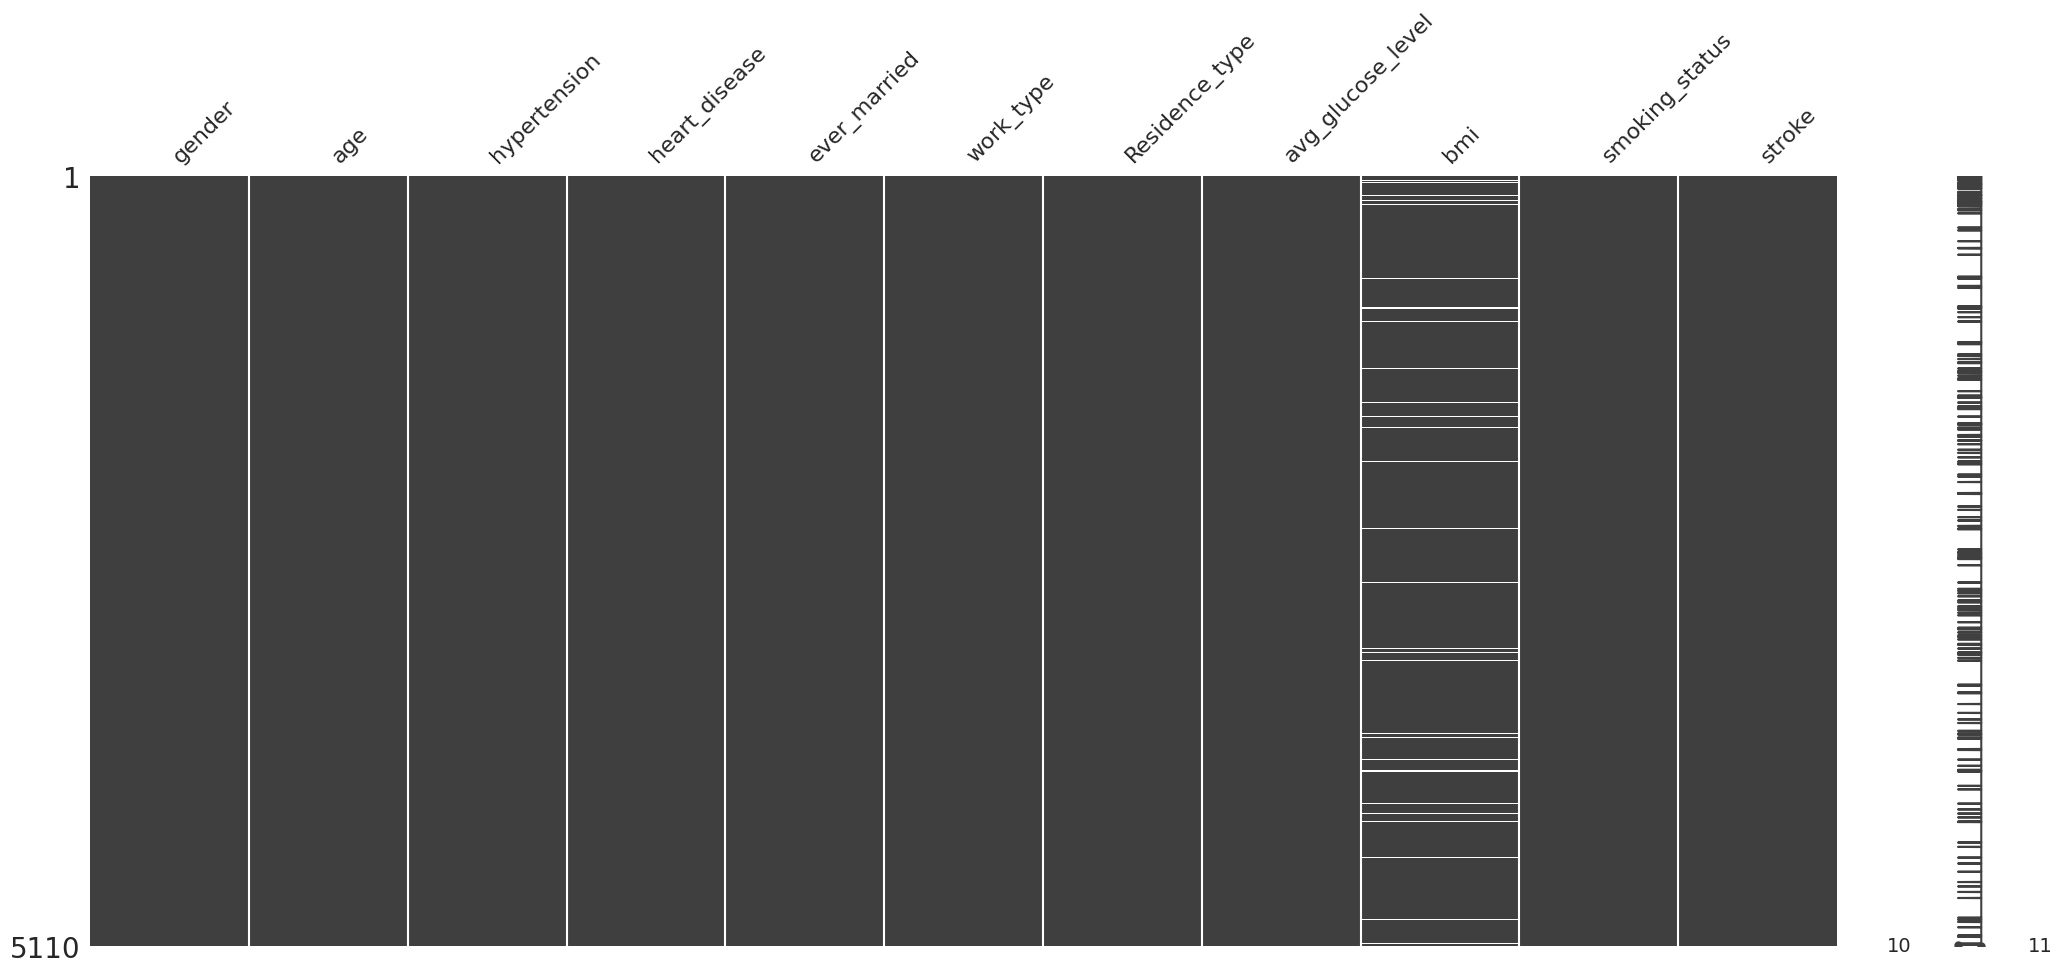

In [6]:
msno.matrix(stroke_df)

Exactamente, el atributo `bmi` tiene 201 nulos, lo que corresponde a aproximadamente el 3% de nuestros datos.

In [7]:
stroke_df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

Vamos a examinar los registros de aquellos pacientes con valores nulos del atributo `bmi`:

In [8]:
stroke_df[stroke_df["bmi"].isnull()]

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
27419,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
8213,Male,78.0,0,1,Yes,Private,Urban,219.84,NaN,Unknown,1
25226,Male,57.0,0,1,No,Govt_job,Urban,217.08,NaN,Unknown,1
61843,Male,58.0,0,0,Yes,Private,Rural,189.84,NaN,Unknown,1
...,...,...,...,...,...,...,...,...,...,...,...
42007,Male,41.0,0,0,No,Private,Rural,70.15,NaN,formerly smoked,0
28788,Male,40.0,0,0,Yes,Private,Urban,191.15,NaN,smokes,0
32235,Female,45.0,1,0,Yes,Govt_job,Rural,95.02,NaN,smokes,0


## Analisis univariado

En este punto vamos a analizar el comportamiento de cada variable por separado, primero examinaremos a las variables categoricas y luego las numericas.

### Variables categoricas

Primero vamos a analizar las variables categoricas, para ello vamos a gráficar diagramas de barras con el fin de obtener una nocion de la frecuencia de cada categoria. Podemos ver que:
- Hay mas mujeres que hombres en la muestra.
- La mayoria de los pacientes no tienen hipertension ni enfermedades del corazon.


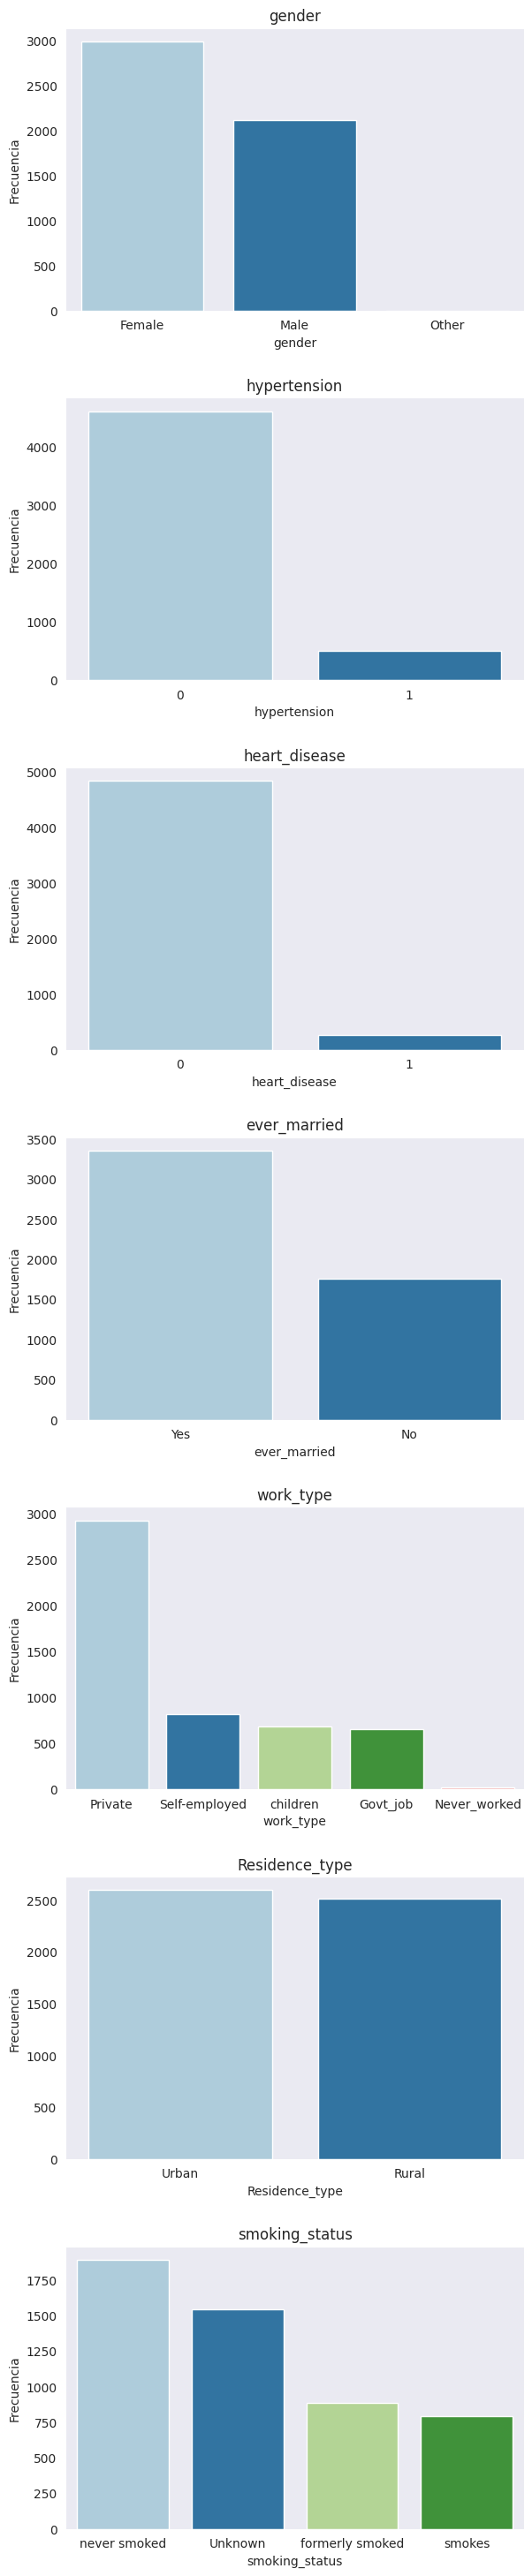

In [9]:
# variable categoricas
cat_attr = ["gender", 
            "hypertension", 
            "heart_disease", 
            "ever_married", 
            "work_type", 
            "Residence_type",
            "smoking_status"]

fig, axes = plt.subplots(7, 1, figsize=(7,30))
fig.tight_layout(pad=5.0)

# diagrama de barras por atributo
for idx, attr in enumerate(cat_attr):
    counts = (stroke_df[attr].value_counts()
                             .reset_index()
                             .rename(columns={attr: "Frecuencia", "index": attr})
             )
    sns.barplot(ax=axes[idx], x=attr, y="Frecuencia", data=counts)
    axes[idx].set_title(attr)

Podemos ver que el atributo de genero `gender` puede tomar el valor `Other`(Otro), examinando a fondo esta categoria nos damos cuenta que solo existe una ocurrencia, lo cual es un tanto extraño.

In [10]:
stroke_df[stroke_df["gender"] == "Other"]

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
56156,Other,26.0,0,0,No,Private,Rural,143.33,22.4,formerly smoked,0


### Variables continuas

Las variable continuas que tenemos corresponden a la edad `age`, el nivel medio de glucosa en la sangre `avg_glucose_level` y el índice de masa corporal `bmi`. De las cuales podemos concluir que:
- La edad tiene una distribución aproximadamente normal.
- La distribución del nivel medio de glusosa esta sesgada a la derecha.
- La distribución del indice de masa corporal esta sesgada a la derecha.

In [11]:
stroke_df[["age", "avg_glucose_level", "bmi"]].describe()

,age,avg_glucose_level,bmi
count,5110.000000,5110.000000,4909.000000
mean,43.226614,106.147677,28.893237
std,22.612647,45.283560,7.854067
min,0.080000,55.120000,10.300000
25%,25.000000,77.245000,23.500000
50%,45.000000,91.885000,28.100000
75%,61.000000,114.090000,33.100000
max,82.000000,271.740000,97.600000


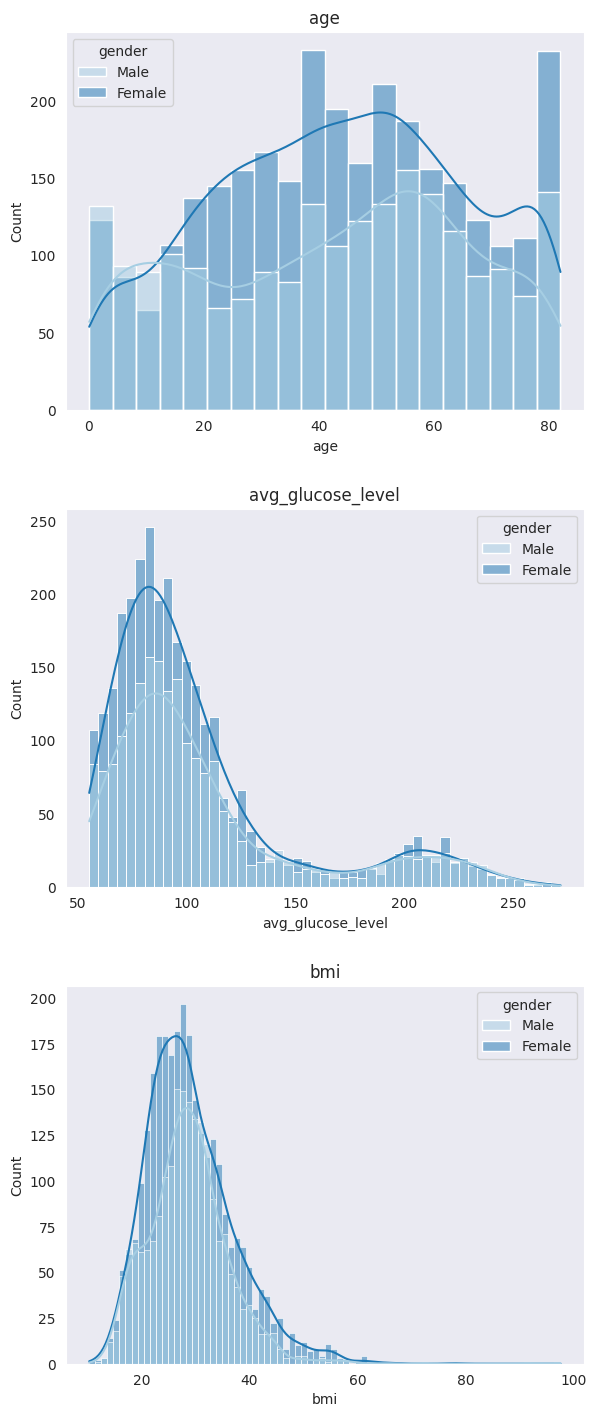

In [12]:
num_attrs = ["age", "avg_glucose_level", "bmi"]

fig, axes = plt.subplots(3, 1, figsize=(7,15))
fig.tight_layout(pad=5.0)

for idx, attr in enumerate(num_attrs):
    sns.histplot(
        x=attr,
        hue="gender", 
        data=stroke_df[stroke_df["gender"] != "Other"], 
        ax=axes[idx], 
        kde=True)
        
    axes[idx].set_title(attr)
    

## Análisis bivariado 

Para analizar los pares de varibales vamos a graficar los diagramas de dispersion de cada uno de estos con el fin de identificar las posibles relaciones que existen. De esto podemos observar que:

1. Es mas frecuente que personas mayores de 40 tengan accidente cardio vascular.
2. La mayoría de las personas tienen el bmi menor a 60.
3. No hay una relación entre el aumento de niveles de glucosa en la sangre con respecto al bmi. 
4. En cualquier edad los niveles de glucosa en la sangre se mantienen menores de 200.


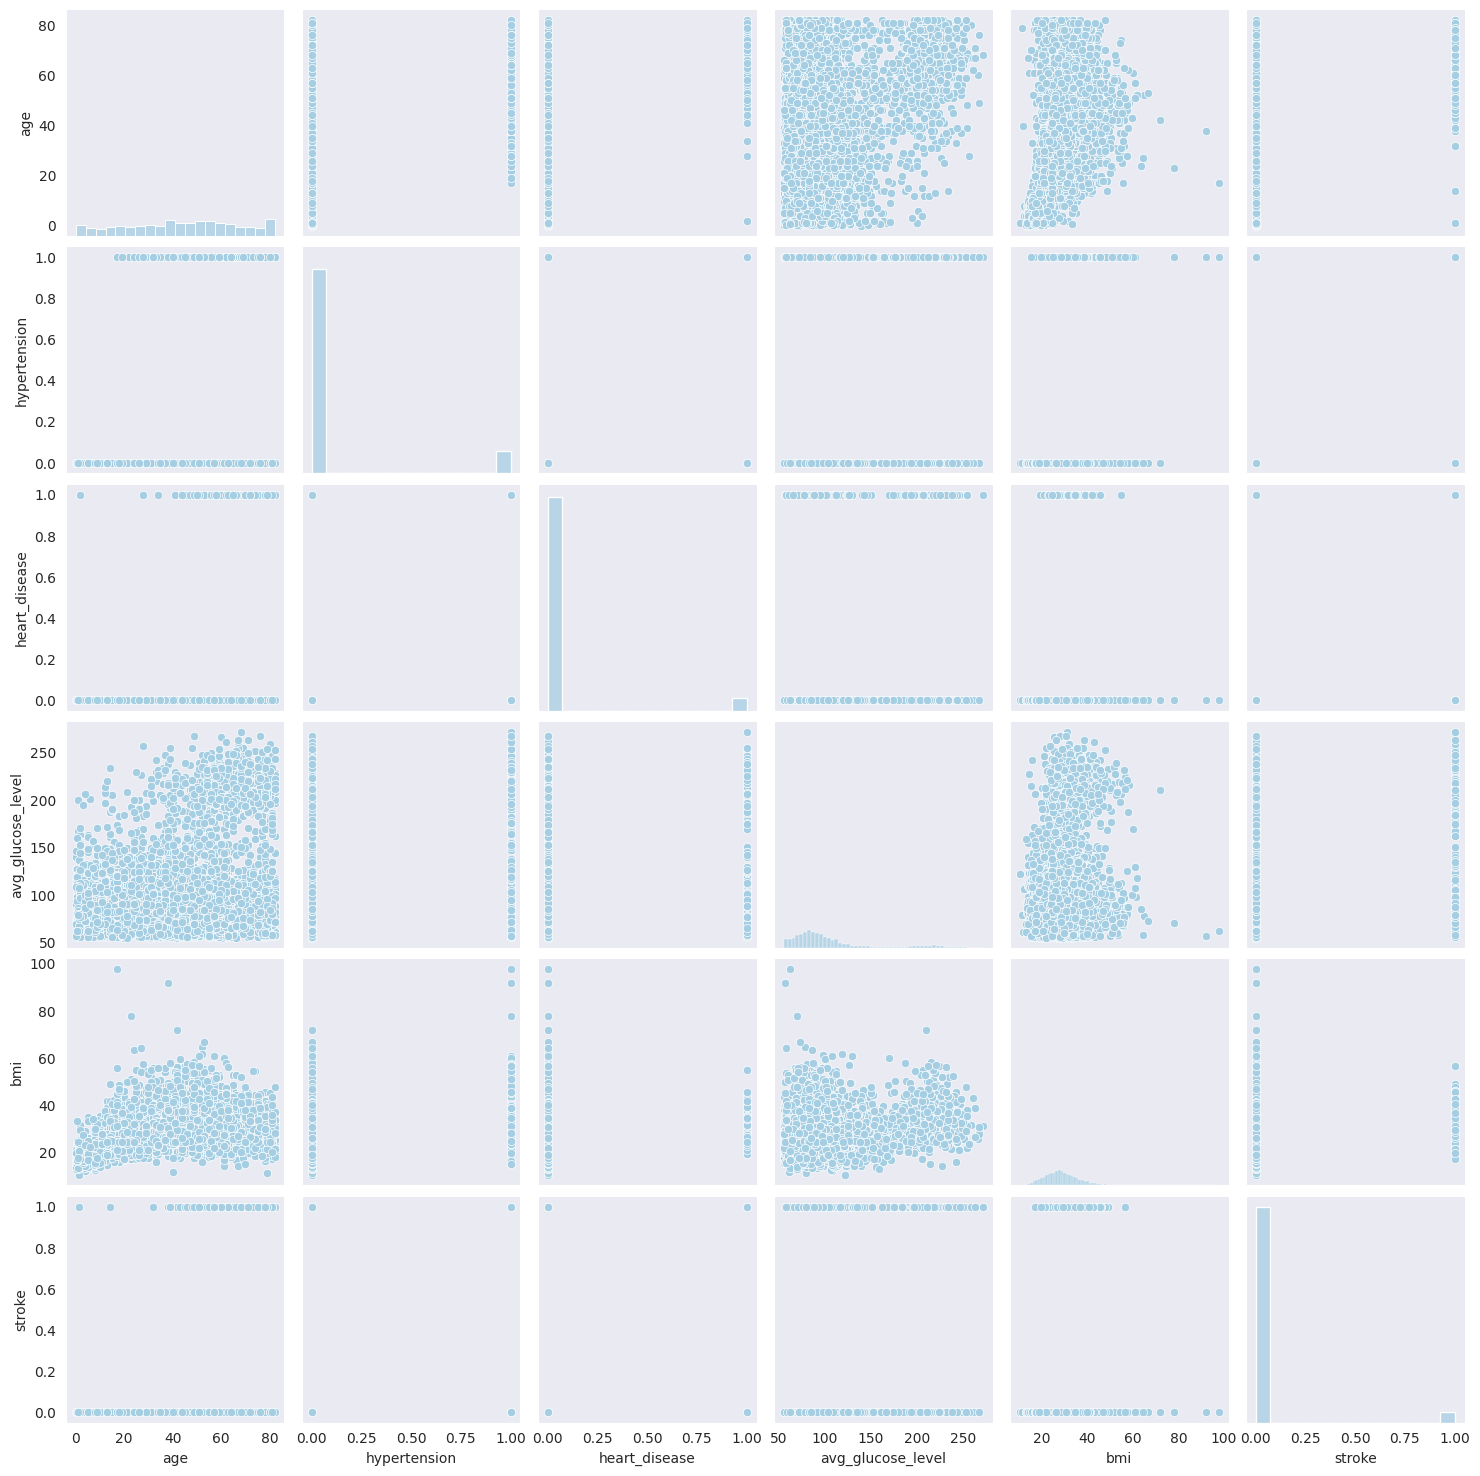

In [13]:
sns.pairplot(stroke_df)
plt.show()

### Análisis de correlacion

Ahora vamos a analizar la correlación entre las variables, para ellos vamos a calcular la matriz de correlación de estas mediante la función `corr()`. Esta por defecto, toma unicamente las variables numericas.

In [14]:
corr_matrix = stroke_df.corr()

corr_matrix

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
age,1.000000,0.276398,0.263796,0.238171,0.333398,0.245257
hypertension,0.276398,1.000000,0.108306,0.174474,0.167811,0.127904
heart_disease,0.263796,0.108306,1.000000,0.161857,0.041357,0.134914
avg_glucose_level,0.238171,0.174474,0.161857,1.000000,0.175502,0.131945
bmi,0.333398,0.167811,0.041357,0.175502,1.000000,0.042374
stroke,0.245257,0.127904,0.134914,0.131945,0.042374,1.000000


Para visualizar mejor los valores de la matriz de correlación vamos a graficar el siguiente mapa de calor. A partir de esta podemos concluir que no existe ninguna correlación apreciable entre las variables.

<AxesSubplot: >

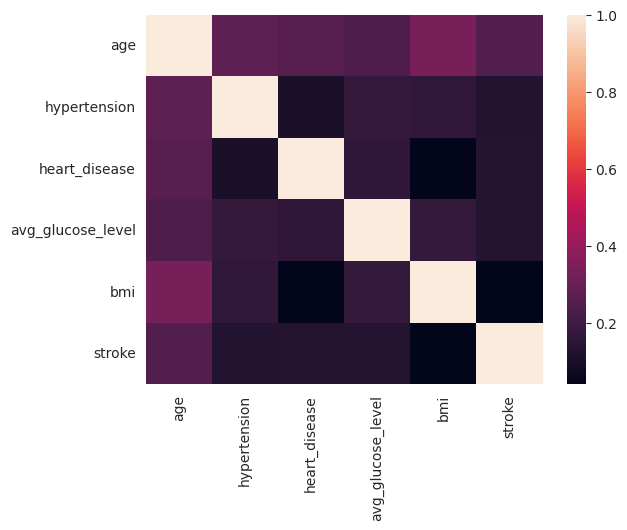

In [15]:
sns.heatmap(corr_matrix)

### Imbalance de clases

El imbalance de clases ocurre cuando hay una clase que tiene muchas mas registros que las demas en un problema de clasificación. En nuestro caso podemos ver que existe un grado morado de imbalance ya que la clase minoritaria, representa el 5% del total de registros del data set.

<AxesSubplot: xlabel='stroke', ylabel='Frecuencia'>

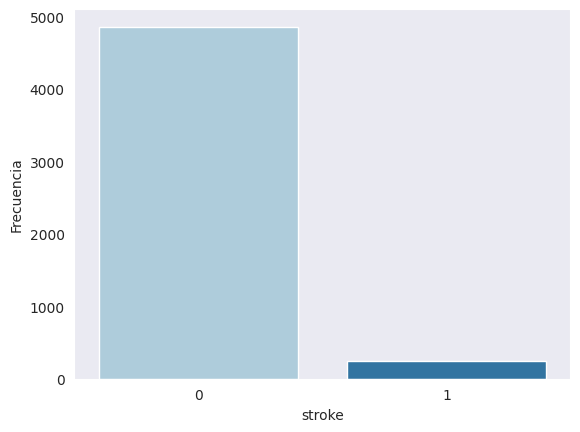

In [16]:
class_counts = (stroke_df["stroke"].value_counts()
                         .reset_index()
                         .rename(columns={"stroke": "Frecuencia", "index": "stroke"})
            )
sns.barplot(x="stroke", y="Frecuencia", data=class_counts)

In [17]:
class_counts["Proporción"] = (class_counts["Frecuencia"] / sum(class_counts["Frecuencia"])).round(2)
class_counts

,stroke,Frecuencia,Proporción
0,0,4861,0.95
1,1,249,0.05


Mas adelante solucionaremos este problema con el algoritmo SMOTE, antes de ajustar nuestro modelo a los datos.

## Limpieza y transformación de los datos

### Tratamiento de valores nulos

Debido a que el modelo que vamos a implementar no tolera la presencia de valores nulos, debemos hacer algún tipo de imputación. En el dataset solo el atributo del índice de masa corporal `bmi` tiene valores nulos. 

Primeramente consideramos las posibles razones detras de esta falta de datos del atributo `bmi`, en este caso puede ser debido a que al paciente nunca se le realizó esta medición, por lo cual tiene sentido imputar los datos con un valor razonable.

Podemos ver que el atributo `bmi` cuenta con bastantes valores atipicos, por esta razon vamos a imputar los datos con la mediana de ya que este valor es restistente a valores atipicos.

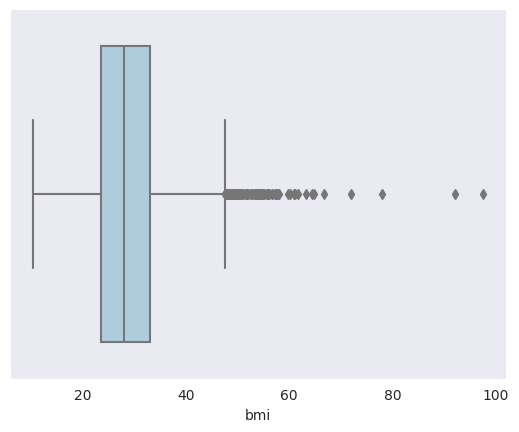

In [18]:
sns.boxplot(x=stroke_df["bmi"])
plt.show()

In [19]:
stroke_df['bmi'].fillna(stroke_df['bmi'].median(),inplace=True)

### Codificación de las variables categoricas

In [20]:
le = LabelEncoder()
for col in stroke_df.select_dtypes(exclude = ['int64', 'float', 'float64', 'int']).columns:
    stroke_df[col] = le.fit_transform(stroke_df[col])
stroke_df.head()


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,1,67.0,0,1,1,2,1,228.69,36.6,1,1
51676,0,61.0,0,0,1,3,0,202.21,28.1,2,1
31112,1,80.0,0,1,1,2,0,105.92,32.5,2,1
60182,0,49.0,0,0,1,2,1,171.23,34.4,3,1
1665,0,79.0,1,0,1,3,0,174.12,24.0,2,1


In [21]:
stroke_df.dtypes

gender                 int64
age                  float64
hypertension           int64
heart_disease          int64
ever_married           int64
work_type              int64
Residence_type         int64
avg_glucose_level    float64
bmi                  float64
smoking_status         int64
stroke                 int64
dtype: object

## Formulación y validación del modelo

Antes de la clasificación que vamos a realizar, primero eliminaremos algunos atributos que no son necesarios en nuestro analisis.

### Clasificación XGBoost

A diferencia de muchos otros algoritmos, XGBoost es un algoritmo de aprendizaje de conjunto, lo que significa que combina los resultados de muchos modelos, llamados aprendices de base, para hacer una predicción.

Al igual que en los bosques aleatorios, XGBoost utiliza árboles de decisión como aprendices de base.

Los árboles de decisión individuales son modelos de bajo sesgo y alta varianza. Son increíblemente buenos a la hora de encontrar las relaciones en cualquier tipo de datos de entrenamiento, pero les cuesta generalizar bien en datos no vistos.

Sin embargo, los árboles utilizados por XGBoost son un poco diferentes a los árboles de decisión tradicionales. Se denominan árboles CART (árboles de clasificación y regresión) y, en lugar de contener una única decisión en cada nodo "hoja", contienen puntuaciones de valor real sobre la pertenencia de una instancia a un grupo. Una vez que el árbol alcanza su máxima profundidad, la decisión puede tomarse convirtiendo las puntuaciones en categorías mediante un determinado umbral.

In [24]:
# Seleccionamos los atributos con los que vamos predecir nuestro atributo objetivo.
X = stroke_df.drop("stroke", axis=1)
# Seleccionamos el atributo a predecir.
y = stroke_df.stroke

### Oversampling utilizando el algoritmo SMOTE

Como vimos anteriormente, tenemos un problema de imbalance de clases en nuestros datos, pues las proporciones de las clases 0 y 1 son 95% y 5%, respectivamente. Esto lo solucionamos utilizando una técnica llamada oversampling, donde usamos un algoritmo llamado SMOTE.

In [25]:
print(Counter(y))

Counter({0: 4861, 1: 249})


In [26]:
smote = SMOTE()

# fit predictor and target variable
X, y = smote.fit_resample(X, y)

In [27]:
print(Counter(y))

Counter({1: 4861, 0: 4861})


In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=1121218
)

In [29]:
# Iniciación de la clasificación
xgb_cl = xgb.XGBClassifier()

# Entrenamiento
xgb_cl.fit(X_train, y_train)

# Predicción
y_preds = xgb_cl.predict(X_test)

In [30]:
# Resultados de comparación con la metrica
accuracy_score(y_test, y_preds)

0.951048951048951

Vamos a entrenar nuestro clasificador XGBoost. Utilizaremos la clase GridSearchCV de Scikit-learn que acepta posibles valores para los hiperparámetros deseados y ajusta modelos separados en los datos dados para cada combinación de hiperparámetros.

Los valores hiperparámetros deseados son:
1. **learning_rate**: También llamado eta, especifica la rapidez con la que el modelo se ajusta a los errores residuales utilizando aprendices de base adicionales.
    - Valores típicos: 0.01-0.2.

2. **gamma, reg_alpha, reg_lambda**: Estos 3 parámetros especifican los valores para 3 tipos de regularización realizados por XGBoost - reducción de pérdidas mínima para crear una nueva división, L1 reg en pesos de hoja, L2 reg pesos de hoja respectivamente.
    - Valores típicos de gamma: 0 - 0,5, pero dependen en gran medida de los datos.
    - Valores típicos para reg_alpha y reg_lambda: 0 - 1 es un buen punto de partida pero, de nuevo, depende de los datos.

3. **max_depth**: La profundidad de los nodos de decisión del árbol. Debe ser un número entero positivo.
    - Valores típicos: 1-10.
 
4. **subsample**: Fracción del conjunto de entrenamiento que puede utilizarse para entrenar cada árbol. Si este valor es bajo, puede llevar a un infra-ajuste o si es demasiado alto, puede llevar a un sobreajuste.
    - Valores típicos: 0.5-0.9

5. **colsample_bytree**: Fracción de las características que pueden utilizarse para entrenar cada árbol. Un valor grande significa que se pueden utilizar casi todas las características para construir el árbol de decisión
    - Valores típicos: 0.5-0.9

Sólo afinaremos algunos de los parámetros en dos rondas, ya que el afinamiento es costoso en términos computacionales y de tiempo. Vamos a crear la red de parámetros para la primera ronda

In [31]:
param_grid = {
    "max_depth": [4, 8, 12],
    "learning_rate": [0.01, 0.05, 0.025],
    "gamma": [0.125, 0.25, 0.375],
    "reg_lambda": [5, 10, 20],
    "scale_pos_weight": [3, 6, 12],
    "subsample": [0.25, 0.5],
    "colsample_bytree": [0.5, 0.7, 0.9],
}

In [32]:
# Iniciación de la clasificacion
xgb_cl = xgb.XGBClassifier(objective="binary:logistic")

# Iniciacion de busqueda la red
grid_cv = GridSearchCV(xgb_cl, param_grid, n_jobs=-1, cv=3, scoring="roc_auc")

# Entrenamiento
fit = grid_cv.fit(X, y)

Con esto obtenemos el siguiente resultado y parametros:

In [33]:
grid_cv.best_score_

0.977143444054018

In [34]:
grid_cv.best_params_

{'colsample_bytree': 0.9,
 'gamma': 0.375,
 'learning_rate': 0.05,
 'max_depth': 12,
 'reg_lambda': 5,
 'scale_pos_weight': 6,
 'subsample': 0.5}

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b0cbb4f4-b0d4-4b78-b7b4-e1881d7a2c49' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>